In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
from copy import copy
from dataset import generate_synthetic_data, calc_true_value, 
from estimators import calc_avg, calc_ips, calc_mips, calc_new_ips, calc_new_mips
from utils import eps_greedy_policy, aggregate_simulation_results, remove_outliers

In [2]:
from sklearn.utils import check_random_state
from scipy.stats import rankdata
import numpy as np
from utils import sample_action_fast, sigmoid, softmax, eps_greedy_policy

In [3]:
def generate_waseda_student_data3(
    num_data: int,
    phi_a: np.ndarray,
    theta_g_0: np.ndarray,#以下q0の値
    M_g_0: np.ndarray,
    b_g_0: np.ndarray,
    theta_h_0: np.ndarray,
    M_h_0: np.ndarray,
    b_h_0: np.ndarray,
    theta_g_1: np.ndarray,  # 以下 q1 の値
    M_g_1: np.ndarray,
    b_g_1: np.ndarray,
    theta_h_1: np.ndarray,
    M_h_1: np.ndarray,
    b_h_1: np.ndarray,
    lambda1_: float ,
    lambda0_: float ,
    dim_context: int ,
    num_actions: int ,
    num_clusters: int ,
    beta: float ,
    num_def_actions: int = 0 ,
    random_state: int = 12345,
) -> dict:
    """行動特徴量を活用したオフ方策評価におけるログデータを生成する."""
    random_ = check_random_state(random_state)
    x = random_.normal(size=(num_data, dim_context))
    one_hot_a, one_hot_c = np.eye(num_actions), np.eye(num_clusters)
    
    # 期待報酬関数1を定義する
    g_x_c_1 = (
            (x - x ** 2 -x**3) @ theta_g_1 + (x ** 3 + x ** 2 ) @ M_g_1 @ one_hot_c + b_g_1
        ) / 10
    h_x_a_1 = (
            (x ** 3 + x ** 2 ) @ theta_h_1 + (x - x ** 2 - x**3) @ M_h_1 @ one_hot_a + b_h_1
        ) / 10
    q_x_a_1 = (1 - lambda1_) * g_x_c_1[:, phi_a] + lambda1_ * h_x_a_1

    #期待報酬関数０を定義する
    g_x_c_0 = (
            (x - x ** 2) @ theta_g_0 + (x ** 3 + x ** 2 - x) @ M_g_0 @ one_hot_c + b_g_0
        ) / 10
    h_x_a_0 = (
            (x ** 3 + x ** 2 - x) @ theta_h_0 + (x - x ** 2) @ M_h_0 @ one_hot_a + b_h_0
        ) / 10
    q_x_a_0 = (1 - lambda0_) * g_x_c_0[:, phi_a] + lambda0_ * h_x_a_0

    #期待報酬関数の差をCATEとして定義
    cate_x_a = q_x_a_1 - q_x_a_0

    #データ収集方策を定義する
    pi_0 = softmax(beta*cate_x_a)
    pi_0[:, :num_def_actions] = 0
    pi_0 = pi_0 / pi_0.sum(1)[:, np.newaxis]

    # 行動や報酬を抽出する
    a = sample_action_fast(pi_0, random_state=random_state)
    a_mat = np.zeros((num_data, num_actions), dtype=int)
    a_mat[np.arange(num_data), a] = 1
    pscore_mat = a_mat * pi_0 + (1 - a_mat) * (1 - pi_0)

    q_x_a_factual = a_mat * q_x_a_1 + (1 - a_mat) * q_x_a_0
    r_mat = random_.normal(q_x_a_factual)
    
    c = phi_a[a]
    c_mat = np.zeros((num_data,num_clusters))
    for i in range(num_data):
        c_mat[i,c[i]] = 1
    

    return dict(
        num_data=num_data, # データの数
        num_actions=num_actions, #アクション数
        num_clusters = num_clusters,
        x=x,  #特徴量
        a=a,   #行動
        c = c, 
        c_mat = c_mat,     
        r=r_mat[np.arange(num_data), a],
        a_mat=a_mat,
        r_mat=r_mat,
        phi_a = phi_a,
        pi_0=pi_0,
        pscore=pi_0[np.arange(num_data), a],
        pscore_mat=pscore_mat,
        g_x_c_1=(1 - lambda1_) * g_x_c_1,
        h_x_a_1=lambda1_ * h_x_a_1,
        g_x_c_0=(1 - lambda0_) * g_x_c_0,
        h_x_a_0=lambda0_ * h_x_a_0,
        q_x_a_1=q_x_a_1,
        q_x_a_0=q_x_a_0,
        cate_x_a=cate_x_a,
    )
    

In [4]:
def generate_waseda_student_data3(
    num_data: int,
    phi_a: np.ndarray,
    theta_g_0: np.ndarray,  # 以下 q0 の値
    M_g_0: np.ndarray,
    b_g_0: np.ndarray,
    theta_h_0: np.ndarray,
    M_h_0: np.ndarray,
    b_h_0: np.ndarray,
    theta_g_1: np.ndarray,  # 以下 q1 の値
    M_g_1: np.ndarray,
    b_g_1: np.ndarray,
    theta_h_1: np.ndarray,
    M_h_1: np.ndarray,
    b_h_1: np.ndarray,
    lambda1_: float,
    lambda0_: float,
    dim_context: int,
    num_actions: int,
    num_clusters: int,
    beta: float,
    num_def_actions: int = 0,
    random_state: int = 12345,
) -> dict:
    """行動特徴量を活用したオフ方策評価におけるログデータを生成する."""
    random_ = check_random_state(random_state)
    x = random_.normal(size=(num_data, dim_context))
    one_hot_a, one_hot_c = np.eye(num_actions), np.eye(num_clusters)
    
    # 期待報酬関数1を定義する
    g_x_c_1 = np.clip(
        ((x - x**2 - x**3) @ theta_g_1 + (x**3 + x**2) @ M_g_1 @ one_hot_c + b_g_1) / 10,
        0,
        None,
    )
    h_x_a_1 = np.clip(
        ((x**3 + x**2) @ theta_h_1 + (x - x**2 - x**3) @ M_h_1 @ one_hot_a + b_h_1) / 10,
        0,
        None,
    )
    q_x_a_1 = np.clip((1 - lambda1_) * g_x_c_1[:, phi_a] + lambda1_ * h_x_a_1, 0, None)

    # 期待報酬関数0を定義する
    g_x_c_0 = np.clip(
        ((x - x**2) @ theta_g_0 + (x**3 + x**2 - x) @ M_g_0 @ one_hot_c + b_g_0) / 10,
        0,
        None,
    )
    h_x_a_0 = np.clip(
        ((x**3 + x**2 - x) @ theta_h_0 + (x - x**2) @ M_h_0 @ one_hot_a + b_h_0) / 10,
        0,
        None,
    )
    q_x_a_0 = np.clip((1 - lambda0_) * g_x_c_0[:, phi_a] + lambda0_ * h_x_a_0, 0, None)

    # 期待報酬関数の差を CATE として定義
    cate_x_a = q_x_a_1 - q_x_a_0

    # データ収集方策を定義する
    pi_0 = softmax(beta * cate_x_a)
    pi_0[:, :num_def_actions] = 0
    pi_0 = pi_0 / pi_0.sum(1)[:, np.newaxis]

    # 行動や報酬を抽出する
    a = sample_action_fast(pi_0, random_state=random_state)
    a_mat = np.zeros((num_data, num_actions), dtype=int)
    a_mat[np.arange(num_data), a] = 1
    pscore_mat = a_mat * pi_0 + (1 - a_mat) * (1 - pi_0)

    q_x_a_factual = np.clip(a_mat * q_x_a_1 + (1 - a_mat) * q_x_a_0, 0, None)
    r_mat = np.clip(random_.normal(q_x_a_factual, scale=0.1), 0, None)  # 報酬を正値に制約

    c = phi_a[a]
    c_mat = np.zeros((num_data, num_clusters))
    cluster_num = np.zeros(num_data, int)
        
    for i in range(num_data):
        c_mat[i, c[i]] = 1
        cluster_num[i] = np.sum(phi_a == c[i])

    return dict(
        num_data=num_data,  # データの数
        num_actions=num_actions,  # アクション数
        num_clusters=num_clusters,
        x=x,  # 特徴量
        a=a,  # 行動
        c=c,
        c_mat=c_mat,
        r=r_mat[np.arange(num_data), a],
        a_mat=a_mat,
        r_mat=r_mat,
        phi_a=phi_a,
        pi_0=pi_0,
        pscore=pi_0[np.arange(num_data), a],
        pscore_mat=pscore_mat,
        g_x_c_1=(1 - lambda1_) * g_x_c_1,
        h_x_a_1=lambda1_ * h_x_a_1,
        g_x_c_0=(1 - lambda0_) * g_x_c_0,
        h_x_a_0=lambda0_ * h_x_a_0,
        q_x_a_1=q_x_a_1,
        q_x_a_0=q_x_a_0,
        cate_x_a=cate_x_a,
        cluster_num= cluster_num
    )


In [5]:
def calc_true_value2(
    dim_context: int,
    num_actions: int,
    num_clusters: int,
    phi_a: np.ndarray,
    theta_g_0,
    M_g_0,
    b_g_0,
    theta_h_0,
    M_h_0,
    b_h_0,
    theta_g_1,
    M_g_1,
    b_g_1,
    theta_h_1,
    M_h_1,
    b_h_1,
    lambda0_,
    lambda1_,
    beta
):
    """評価方策の真の性能を近似する."""
    test_bandit_data = generate_waseda_student_data3(
        num_data=10000,
        dim_context=dim_context,
        num_actions=num_actions,
        num_clusters=num_clusters,
        phi_a=phi_a,
        theta_g_0=theta_g_0,
        M_g_0=M_g_0,
        b_g_0=b_g_0,
        theta_h_0=theta_h_0,
        M_h_0=M_h_0,
        b_h_0=b_h_0,
        theta_g_1=theta_g_1,
        M_g_1=M_g_1,
        b_g_1=b_g_1,
        theta_h_1=theta_h_1,
        M_h_1=M_h_1,
        b_h_1=b_h_1,
        lambda0_=lambda0_,
        lambda1_=lambda1_,
        beta=beta,
    )

    cate_x_a = test_bandit_data["cate_x_a"]
    pi =eps_greedy_policy(cate_x_a)
    
    q_x_a_1 =test_bandit_data["q_x_a_1"]
    q_x_a_0 = test_bandit_data["q_x_a_0"]

    return ((q_x_a_1-q_x_a_0)*pi).sum(1).mean()
    #return (q_x_a_0*pi).sum(1).mean()
    #return (q_x_a_1*pi).sum(1).mean()


In [6]:
def calc_new_mips_takashi(
    dataset:dict, 
    pi:np.ndarray,
    replace_c:int = 0,
    is_estimate_w: bool = False
    ) ->float:
    
    num_data = dataset["num_data"]
    num_actions, num_clusters = dataset["num_actions"], dataset["num_clusters"]
    x, a, c, r = dataset["x"], dataset["a"], copy(dataset["c"]),dataset["r"]
    pi_0, phi_a = dataset["pi_0"], copy(dataset["phi_a"])
    min_value, max_value = r.min(), r.max()
    #actionしない行動確率を定義
    a_mat, r_mat = dataset["a_mat"], copy(dataset["r_mat"])
    c_mat = dataset["c_mat"]
    not_c_mat = 1 - c_mat

 
    if replace_c > 0:
        #replace_c個のクラスタをnum_clusters - replace_c - 1に結合
        c[c >= num_clusters - replace_c] = num_clusters - replace_c - 1
        phi_a[phi_a >= num_clusters - replace_c] = num_clusters - replace_c - 1


    if is_estimate_w:#p(a|e,x)の推定
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        print(x.shape)
        print(x_c.shape)
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        print(pi_a_x_c_hat.shape)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        return np.clip((w_x_c_hat * r).mean(), min_value, max_value)

    else:#p(e|a,x)=1としている
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        r_c_mat = np.zeros((num_data, num_clusters - replace_c))
        
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
            
            r_c_mat[:,c_] = r_mat[:,phi_a == c_].sum(1)
            
        # (1) π(e_i|x_i) / π_0(e_i|x_i) * r_i(e_i, 0)
        w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
        #term1 = w_x_c_1 * r  # 第一項

        # (2) Σ_(e ∈ E/{e_i}) ((1 - π(e|x)) / (1 - π_0(e|x)) * r_i(e, 0))
        # 非選択アクションの重みと報酬を計算
        #denom = 1 - (pi_0_c * not_c_mat)  # 1 - π_0(e|x)
        #denom[denom == 0] = 1  # ゼロ割りを防止
        #w_x_c_0 = (not_c_mat - (pi_c * not_c_mat)) / denom  # 重み
        #w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)     # NaN を 0 に置換
        #term2 = (w_x_c_0 * r_c_mat).sum(axis=1)     # 第二項
        
        w_x_c_0 = (pi_c* not_c_mat)/ (not_c_mat -(pi_0_c*not_c_mat))
        #nanを０に変更
        w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
        #print(w_x_c_1.shape)
        #print(w_x_c_0.shape)
        #print(w_x_c_0[0])
        
        
        #print((w_x_c_1 * r).shape)
        #print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
        
        # 全体の報酬
        #total_reward = term1 + term2
        #return total_reward.mean()
        #print("w_x_c_0*r_c_mat:" ,(w_x_c_0*r_c_mat).shape)
        temp1 = w_x_c_1 * r 
        temp2 = (w_x_c_0*r_c_mat).sum(1)
        #return np.clip((temp1-temp2).mean(), min_value, max_value)
        return temp2.mean()
    
    

In [7]:
def calc_new_mips_takashi2(
    dataset:dict, 
    pi:np.ndarray,
    q0_hat,
    ) ->float:
    
    num_data = dataset["num_data"]
    num_actions, num_clusters = dataset["num_actions"], dataset["num_clusters"]
    x, a, c, r = dataset["x"], dataset["a"], dataset["c"],dataset["r"]
    pi_0, phi_a = dataset["pi_0"], dataset["phi_a"]
    min_value, max_value = r.min(), r.max()
    #actionしない行動確率を定義
    a_mat, r_mat = dataset["a_mat"], dataset["r_mat"]
    c_mat = dataset["c_mat"]
    not_c_mat = 1 - c_mat


  #p(e|a,x)=1としている
    pi_0_c = np.zeros((num_data, num_clusters ))
    pi_c = np.zeros((num_data, num_clusters ))
    r_c_mat = np.zeros((num_data, num_clusters ))
        
    for c_ in range(num_clusters ):
        pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
        pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
        r_c_mat[:,c_] = r_mat[:,phi_a == c_].sum(1)
           
    # (1) π(e_i|x_i) / π_0(e_i|x_i) * r_i(e_i, 0)
    #w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
    
    w_x_c_1 = (pi_c*c_mat)/pi_0_c
        
    w_x_c_0 = (2 * pi_c* not_c_mat)/ (1 - pi_0_c)
        #nanを０に変更
    w_x_c_1 = np.nan_to_num(w_x_c_1,nan=0)
    w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
    #print(w_x_c_1.shape)
    #print(w_x_c_0.shape)
    #print(w_x_c_0[0])
        
        
    #print((w_x_c_1 * r).shape)
    #print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
       
    # 全体の報酬
    #total_reward = term1 + term2
    #return total_reward.mean()
    #print("w_x_c_0*r_c_mat:" ,(w_x_c_0*r_c_mat).shape)
    
    
    """q1(x,e)によって発生する|ε|*q0(x,a')の重みの追加"""
    temp3 =  q0_hat[np.arange(num_data),a]
    #print(f"temp3:{temp3[0]}")
    temp1 = w_x_c_1 * r_c_mat
    #print(f"temp1:{temp1[0]}")
    #temp1 = w_x_c_1.sum(1) * r
    temp2 = w_x_c_0*r_c_mat
    #print(f"temp2:{temp2[0]}")
    return (temp1.sum(1) -temp2.sum(1) + temp3).mean()
    #return temp2.sum(1).mean()
    #return temp1.sum(1).mean()

### 12/21 提案手法

In [8]:
def calc_new_mips_takashi2(
    dataset:dict, 
    pi:np.ndarray,
    a_cluster_mat,
    ) ->float:
    
    num_data = dataset["num_data"]
    num_actions, num_clusters = dataset["num_actions"], dataset["num_clusters"]
    x, a, c, r = dataset["x"], dataset["a"], dataset["c"],dataset["r"]
    pi_0, phi_a = dataset["pi_0"], dataset["phi_a"]
    min_value, max_value = r.min(), r.max()
    #actionしない行動確率を定義
    a_mat, r_mat = dataset["a_mat"], dataset["r_mat"]
    c_mat = dataset["c_mat"]
    not_c_mat = 1 - c_mat


  #p(e|a,x)=1としている
    pi_0_c = np.zeros((num_data, num_clusters ))
    pi_c = np.zeros((num_data, num_clusters ))
    r_c_mat = np.zeros((num_data, num_clusters ))
        
    for c_ in range(num_clusters ):
        pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
        pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
        r_c_mat[:,c_] = r_mat[:,phi_a == c_].sum(1)
           
    # (1) π(e_i|x_i) / π_0(e_i|x_i) * r_i(e_i, 0)
    #w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
    
    w_x_c_1 = (pi_c*c_mat)/pi_0_c
        
    w_x_c_0 = ( pi_c* not_c_mat)/ (1 - pi_0_c)
        #nanを０に変更
    w_x_c_1 = np.nan_to_num(w_x_c_1,nan=0)
    w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
    #print(w_x_c_1.shape)
    #print(w_x_c_0.shape)
    #print(w_x_c_0[0])
        
        
    #print((w_x_c_1 * r).shape)
    #print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
       
    # 全体の報酬
    #total_reward = term1 + term2
    #return total_reward.mean()
    #print("w_x_c_0*r_c_mat:" ,(w_x_c_0*r_c_mat).shape)

    #print(f"temp3:{temp3[0]}")
    r_hat  = a_cluster_mat.sum(1)
    
    #print(f"temp1:{temp1[0]}")
    temp1 = w_x_c_1.sum(1) * (r + r_hat)
    temp2 = w_x_c_0*r_c_mat
    #print(f"temp2:{temp2[0]}")
    return (temp1 -temp2.sum(1) ).mean()
    #return temp2.sum(1).mean()
    #return temp1.sum(1).mean()

## 12/25

In [9]:
def calc_new_mips_takashi2(
    dataset:dict, 
    pi:np.ndarray,
    cluster_num,
    ) ->float:
    
    num_data = dataset["num_data"]
    num_actions, num_clusters = dataset["num_actions"], dataset["num_clusters"]
    x, a, c, r = dataset["x"], dataset["a"], dataset["c"],dataset["r"]
    pi_0, phi_a = dataset["pi_0"], dataset["phi_a"]
    min_value, max_value = r.min(), r.max()
    #actionしない行動確率を定義
    a_mat, r_mat = dataset["a_mat"], dataset["r_mat"]
    c_mat = dataset["c_mat"]
    not_c_mat = 1 - c_mat


  #p(e|a,x)=1としている
    pi_0_c = np.zeros((num_data, num_clusters ))
    pi_c = np.zeros((num_data, num_clusters ))
    r_c_mat = np.zeros((num_data, num_clusters ))
        
    for c_ in range(num_clusters ):
        pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
        pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
        r_c_mat[:,c_] = r_mat[:,phi_a == c_].sum(1)
           
    # (1) π(e_i|x_i) / π_0(e_i|x_i) * r_i(e_i, 0)
    #w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
    
    w_x_c_1 = (pi_c*c_mat)/pi_0_c
        
    w_x_c_0 = ( pi_c* not_c_mat)/ (1 - pi_0_c)
        #nanを０に変更
    w_x_c_1 = np.nan_to_num(w_x_c_1,nan=0)
    w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
         
  
    temp1 = w_x_c_1.sum(1) * r 
    temp2 = w_x_c_0*r_c_mat
    
    #print(f"temp2:{temp2[0]}")
    return (temp1 - temp2.sum(1) ).mean()
    #return temp2.sum(1).mean()
    #return temp1.mean()

In [10]:
cluster_num = np.zeros(5,int)
phi_a = [1,2,3,4,5,6,4,2,2,4,5,6,3,2,1]
c = [5,2,3,2,1]
for i in range(len(c)):
    cluster_num[i] = phi_a.count(c[i])
    
print(cluster_num)
    
    

[2 4 2 4 2]


In [11]:
print(len(c))

5


In [12]:
a = np.array([[1,2],[0,3]])
b = np.array([[1,2],[1,1]])

print(a/b)
print(a+b)
print((a+b).sum(1))
print((a+b).sum(1).mean())
print(((a+b).sum(1)).mean())

[[1. 1.]
 [0. 3.]]
[[2 4]
 [1 4]]
[6 5]
5.5
5.5


In [13]:
print(a[:,:0])

[]


In [14]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_clusters = 50 # 行動クラスタ数
num_data = 500 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
lambda1_ = 0.0 # クラスタ効果と残差効果の配合率
lambda0_ = 0.0
random_state = 12345
random1_ = check_random_state(random_state)
random0_ = check_random_state(random_state+22)
random_ = check_random_state(random_state+1)
num_actions_list = [250, 500, 1000] # 行動数, |A|

In [15]:

y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}



In [19]:
print(M_g_0)

[[ 0.38891659  0.81538373 -0.55783045  0.58177086 -0.43192956  1.55735051
   1.98114874 -1.34766489 -1.06468626  0.42651421 -0.88704359 -0.6627808
   1.10866249  0.49501068 -1.14894616 -0.13776734 -0.51476685 -0.07786348
  -0.92060268 -0.16373255 -0.86650274  1.14803927 -0.58756878 -1.21414003
  -2.75465668  1.83698712 -0.91773567 -0.2777863   0.80771723 -1.2257669
   0.0436376   0.16727577  0.42791476 -0.18937547  1.14348355 -0.58837349
   0.03106784  0.92020771  0.5857872  -0.67886817 -0.12422952 -1.48959221
   1.13822426  0.18889079  0.14882474 -2.25188854  0.06977972  0.24252046
  -0.94907824  1.12784641]
 [-0.82040597  2.05093064 -1.36047189  2.0230884   0.32416064  0.66142632
   0.42887755  1.57020537 -0.20180493  1.59707187  0.36612101  0.16847201
   1.6222151  -0.1045724  -0.43015537  0.76499165 -0.53145635 -0.59063336
   0.04186406  0.2902613  -0.46716148 -2.22067504  0.9648035   0.65178403
   0.4280491  -0.79580381  1.62060083  0.93026083  0.2032194   0.21464528
   2.30349752

In [17]:
result_df_list = []
theta_g_1 = random1_.normal(size=(dim_context, num_clusters))
M_g_1 = random1_.normal(size=(dim_context, num_clusters))
b_g_1 = random1_.normal(size=(1, num_clusters))
theta_g_0 = random0_.normal(size=(dim_context, num_clusters))
M_g_0 = random0_.normal(size=(dim_context, num_clusters))
b_g_0 = random0_.normal(size=(1, num_clusters))

for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    #phi_a = random_.choice(num_clusters, size=num_actions)
    phi_a = random_.choice(num_clusters, size=num_actions)

    theta_h_1 = random1_.normal(size=(dim_context, num_actions))
    M_h_1 = random1_.normal(size=(dim_context, num_actions))
    b_h_1 = random1_.normal(size=(1, num_actions))

    theta_h_0 = random0_.normal(size=(dim_context, num_actions))
    M_h_0 = random0_.normal(size=(dim_context, num_actions))
    b_h_0 = random0_.normal(size=(1, num_actions))
    

    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value2(
        dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, phi_a=phi_a,
        theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
        M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
        b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
        b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,beta=beta
    )

    estimated_policy_value_list = []        
        
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_waseda_student_data3(
            num_data=num_data, phi_a=phi_a,
            theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
            M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
            b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
            b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters,beta=beta, random_state = _
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])
     
        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["ips"] = calc_new_ips(offline_logged_data, pi)
        estimated_policy_values["mips"] = calc_new_mips(
            offline_logged_data, pi)
        #print(estimated_policy_values["mips"])
        #estimated_policy_values["mips (w_hat)"] = calc_mips(offline_logged_data, pi, is_estimate_w=True)
        estimated_policy_value_list.append(estimated_policy_values)
        

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
    
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

num_actions=1000...: 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


In [319]:
print(offline_logged_data["g_x_c_0"][0][0])
print(offline_logged_data["g_x_c_1"][0][0])
print(offline_logged_data["q_x_a_0"][0][0])
print(offline_logged_data["q_x_a_1"][0][0])
print(offline_logged_data["cate_x_a"][0][0])
print(offline_logged_data["r_mat"])


0.4143917855194855
1.430154848830344
0.9265041208846426
0.6893190815358936
-0.23718503934874902
[[1.12447449 0.01309811 1.5307725  ... 0.02489885 0.80968307 1.26431459]
 [0.15266182 0.06174028 0.60006577 ... 0.85594118 0.92509639 0.70869367]
 [0.30034593 0.         1.02574989 ... 0.03340471 0.50561346 0.60698434]
 ...
 [0.14387325 0.         0.71131888 ... 0.         1.51406536 1.43254434]
 [0.34209977 0.04564493 0.04838193 ... 0.24894833 0.28076077 0.        ]
 [0.3874619  0.07216516 0.75521059 ... 0.8794729  0.1825587  0.85279475]]


In [320]:
result_df_actions

,index,est,value,num_actions,se,bias,variance,true_value
0,0,ips,0.998372,250,0.170760,0.002517,0.214741,1.411603
1,0,mips,0.730002,250,0.464580,0.287304,0.021197,1.411603
2,1,ips,0.517842,250,0.798808,0.002517,0.891006,1.411603
3,1,mips,-0.037561,250,2.100075,0.287304,0.833854,1.411603
4,2,ips,2.262140,250,0.723414,0.002517,0.640586,1.411603
...,...,...,...,...,...,...,...,...
295,47,mips,0.640561,1000,0.629829,5.298945,2.275047,1.434179
296,48,ips,0.793155,1000,0.410912,0.195729,1.173836,1.434179
297,48,mips,-1.382567,1000,7.934058,5.298945,0.265021,1.434179
298,49,ips,17.818429,1000,268.443646,0.195729,254.142165,1.434179


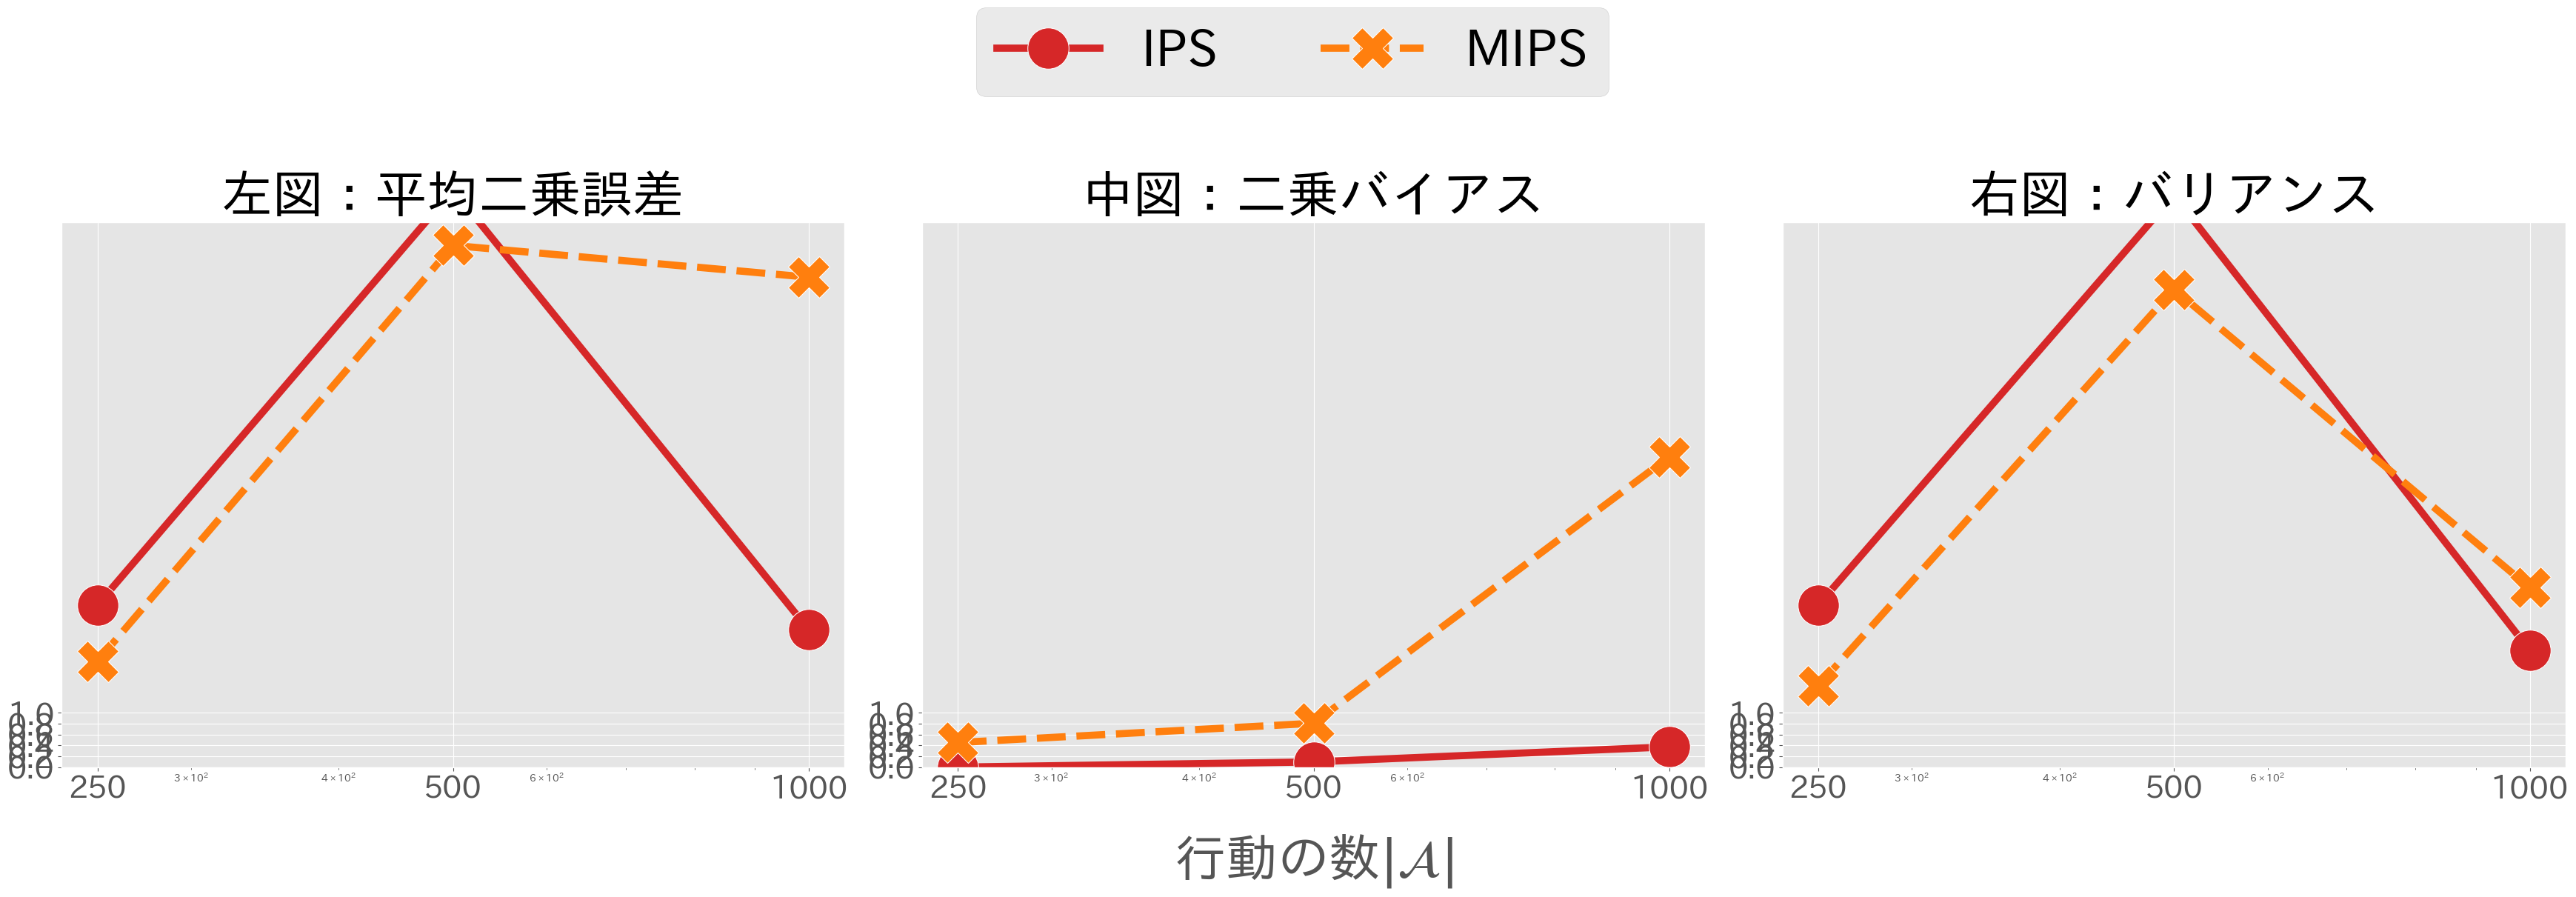

In [18]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange"],
        data=result_df_actions.query("est == 'ips' or est == 'mips'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 10)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["IPS", "MIPS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")

In [322]:
num_data = offline_logged_data["num_data"]
num_actions, num_clusters = offline_logged_data["num_actions"], offline_logged_data["num_clusters"]
x, a, c, r = offline_logged_data["x"], offline_logged_data["a"], copy(offline_logged_data["c"]),offline_logged_data["r"]
pi_0, phi_a = offline_logged_data["pi_0"], copy(offline_logged_data["phi_a"])
min_value, max_value = r.min(), r.max()
#actionしない行動確率を定義
a_mat, r_mat = offline_logged_data["a_mat"], copy(offline_logged_data["r_mat"])
not_a_mat = 1 - a_mat
c_mat = offline_logged_data["c_mat"]
not_c_mat = 1 - c_mat

In [ ]:
is_estimate_w=False
replace_c = 0
if is_estimate_w:#p(a|e,x)の推定
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        print(x.shape)
        print(x_c.shape)
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        print(pi_a_x_c_hat.shape)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        print(np.clip((w_x_c_hat * r).mean(), min_value, max_value))

else:#p(e|a,x)=1としている
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        
        r_c_mat = np.zeros((num_data, num_clusters - replace_c))
        r_mat_not_a = r_mat * (1-a_mat)
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
            
            r_c_mat[:,c_] = r_mat_not_a[:,phi_a == c_].sum(1)
            
    
            
        
        not_r_c_mat = r_c_mat * not_c_mat
        # 周辺重要度重み
        w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
        w_x_c_0 = (not_c_mat - (pi_c*not_c_mat))/ (not_c_mat-(pi_0_c*not_c_mat))
        #nanを０に変更
        w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
        #print(w_x_c_1)
        print(w_x_c_0)
        #print(w_x_c_0[0])
        print(not_r_c_mat.shape)
        
        print((w_x_c_1 * r).shape)
        print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
        print(np.clip((w_x_c_1 * r + ((w_x_c_0*not_r_c_mat).sum(1))).mean(), min_value, max_value))  
    
    
    


[[1.01462348 1.01938688 1.02677865 ... 1.01968298 1.02033091 1.01750462]
 [1.02278045 1.01930266 1.02147112 ... 1.01590934 1.01656471 1.01302959]
 [1.01656705 1.0191907  1.02470634 ... 1.01687437 1.02012499 1.0173278 ]
 ...
 [1.01156701 1.01914555 1.02483425 ... 1.0188873  1.0200776  1.02001858]
 [1.01533944 1.01911456 1.02367791 ... 1.01941884 1.02004507 1.02035428]
 [1.0223926  1.01863856 1.02130986 ... 1.01649156 1.01948237 1.01492368]]
(500, 50)
(500,)
(500,)
7.280686752594123


In [324]:
a = np.array([[1,2],[0,3]])
b = np.array([[1,2],[1,1]])

c = a.sum(1) - b.sum(1)
print(c)

[0 1]


In [325]:
num_data = offline_logged_data["num_data"]
num_actions, num_clusters = offline_logged_data["num_actions"], offline_logged_data["num_clusters"]
x, a, c, r = offline_logged_data["x"], offline_logged_data["a"], copy(offline_logged_data["c"]),offline_logged_data["r"]
pi_0, phi_a = offline_logged_data["pi_0"], copy(offline_logged_data["phi_a"])
min_value, max_value = r.min(), r.max()
#actionしない行動確率を定義
a_mat, r_mat = offline_logged_data["a_mat"], copy(offline_logged_data["r_mat"])
c_mat = offline_logged_data["c_mat"]
not_c_mat = 1 - c_mat


  #p(e|a,x)=1としている
pi_0_c = np.zeros((num_data, num_clusters ))
pi_c = np.zeros((num_data, num_clusters ))
r_c_mat = np.zeros((num_data, num_clusters ))
        
for c_ in range(num_clusters ):
        pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
        pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
        r_c_mat[:,c_] = r_mat[:,phi_a == c_].sum(1)
           
    # (1) π(e_i|x_i) / π_0(e_i|x_i) * r_i(e_i, 0)
    #w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
    
w_x_c_1 = (pi_c*c_mat)/pi_0_c
        #term1 = w_x_c_1 * r  # 第一項

        # (2) Σ_(e ∈ E/{e_i}) ((1 - π(e|x)) / (1 - π_0(e|x)) * r_i(e, 0))
        # 非選択アクションの重みと報酬を計算
        #denom = 1 - (pi_0_c * not_c_mat)  # 1 - π_0(e|x)
        #denom[denom == 0] = 1  # ゼロ割りを防止
        #w_x_c_0 = (not_c_mat - (pi_c * not_c_mat)) / denom  # 重み
        #w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)     # NaN を 0 に置換
        #term2 = (w_x_c_0 * r_c_mat).sum(axis=1)     # 第二項
        
w_x_c_0 = (2 * pi_c* not_c_mat)/ (1 -pi_0_c)
        #nanを０に変更
w_x_c_1 = np.nan_to_num(w_x_c_1,nan=0)
w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
    #print(w_x_c_1.shape)
    #print(w_x_c_0.shape)
    #print(w_x_c_0[0])
        
        
    #print((w_x_c_1 * r).shape)
    #print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
       
    # 全体の報酬
    #total_reward = term1 + term2
    #return total_reward.mean()
    #print("w_x_c_0*r_c_mat:" ,(w_x_c_0*r_c_mat).shape)
temp1 = w_x_c_1 * r_c_mat
temp2 = w_x_c_0*r_c_mat
print((temp1.sum(1)-temp2.sum(1)).mean())

2.4753792990219536


In [326]:
print(r_mat.sum(1)[2])

236.06163973825142


In [327]:
print(r_c_mat.sum(1)[2])

236.06163973825142


In [328]:
print(r_c_mat[0])

[ 7.55800873  0.67305103 34.60750347  1.19230238  0.57271367  4.86649531
  2.55847763 27.55893564 26.16211466  0.32462425  8.36904262  0.52501751
  0.50387134  3.9299159   0.33986076 33.75028767 23.41245877  0.72498429
  0.95021446  1.10723955 34.60678899  0.67029291 22.44337089  1.04433561
 19.21821102 13.80405234  0.46187645  4.85775968  6.39058888 24.27603392
  0.34572344 12.02426519  2.30220089  0.5759092  45.85468088  1.9546202
  0.88117075 24.47858766 15.05981428  1.69777326  1.65720821  1.32185237
 23.94871514 17.59727742 21.17067378  7.24551942  0.69357803 38.36342281
  0.74986009  0.96469105]


In [329]:
print(w_x_c_0[0])

[0.00406663 0.00429043 0.00473407 0.00385534 0.00386144 0.00406238
 0.00448293 0.00516155 0.00410703 0.00408194 1.81868866 0.00283148
 0.00345203 0.00325449 0.00222456 0.00559527 0.00347818 0.00429043
 0.00491848 0.00345902 0.00411566 0.00449935 0.         0.00636103
 0.0044908  0.00324798 0.00384869 0.00406096 0.00243239 0.00515638
 0.00406959 0.00284108 0.00387021 0.00325223 0.00561345 0.0034608
 0.0040617  0.0053463  0.00426904 0.00529037 0.00283639 0.00468452
 0.00452507 0.00451102 0.00326887 0.00263836 0.00448107 0.00408691
 0.00449935 0.00387388]


In [330]:
print(w_x_c_0[0]*r_c_mat[0])

[3.07356036e-02 2.88768157e-03 1.63834349e-01 4.59673306e-03
 2.21149978e-03 1.97695637e-02 1.14694809e-02 1.42246861e-01
 1.07448546e-01 1.32509770e-03 1.52206829e+01 1.48657711e-03
 1.73937905e-03 1.27898759e-02 7.56041112e-04 1.88841968e-01
 8.14327915e-02 3.11049785e-03 4.67361404e-03 3.82996648e-03
 1.42429873e-01 3.01588549e-03 0.00000000e+00 6.64305151e-03
 8.63051403e-02 4.48352574e-02 1.77761996e-03 1.97271616e-02
 1.55444245e-02 1.25176354e-01 1.40695428e-03 3.41618495e-02
 8.91000532e-03 1.87298892e-03 2.57403162e-01 6.76454865e-03
 3.57904931e-03 1.30869865e-01 6.42909106e-02 8.98185141e-03
 4.70048248e-03 6.19224822e-03 1.08369712e-01 7.93817460e-02
 6.92042053e-02 1.91163240e-02 3.10797384e-03 1.56787693e-01
 3.37388642e-03 3.73709535e-03]


In [331]:
print(w_x_c_1[0]*r_c_mat[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.88535896 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [332]:
print((w_x_c_1[0]*r_c_mat[0]).sum() - (w_x_c_0[0]*r_c_mat[0]).sum())

-15.538177369177106


In [333]:
print(offline_logged_data["c_mat"][0,:])
print(offline_logged_data["phi_a"])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[37 18  8 11 36 18 17 17 27 23 47 11 19 23 40 14 35 29 43  3 22  0 15 39
 16 37 27 41 20 11 32 41  8 41 16 34 35 34 38 36 33  1 43  2  5  0  0  5
 36  0 26 31 45 39 48 21 14  2 42 14 17 13 39  8 48  2 25  1  7  1  5 20
 23 36  5  2 47 29 39 12 15 11 12 35 21 49 27 46 10 20  5 42 14 28 28  6
  1 18 32 29 15 36 49 19 18 22 43  1 32 24 33 26  7 27 23  3 23 12 22 22
 32 37 20 49 49 46  0 27 47  2 13 40 24 21 17  5 22 33  8 41 40 27 30 35
 15 31 43 17  7  6 41 18 46 37  7 38 28 32 44 28 42 30 44  6  0 29  4 29
 12 20 15 18 47  6 25 38 24  4 19 25 33 34 40 34 29 18 18 42 46 12  3 21
 47 12 25 15 40 24 49 36 21 18 41 28  5 30 37  9 33 28 36 11 35  0 23  2
 39  2 19 22  8 37 29  4 18 23 19 18 19 20 17 29 36 26 35 34 29 23 31 39
 15  4 19 32 32 25  6 33 25  4 26  4 24 21  7 46  9 49 44 41 15  1 23  6
 16  0  9 18 27 38 43 47 39  4 35  0 46 44 

In [334]:
indices = np.where(offline_logged_data["a_mat"][0, :] == 1)
print(indices)

(array([303], dtype=int64),)


In [335]:
print(offline_logged_data["phi_a"][303])

22


In [336]:
print(offline_logged_data["a"])

[303 245 926 892 682 566 549 211 769 897 722 498 443 801 846 231 962  59
 287 311 701 706 945 605 355 420 906 253 301  77 251 909 843 639 990 941
 855 921 662 393 582 378 484 360 164 898 542 820 566   6 629 769 315  27
  90 255 615 831  10 684 137 928 621 989 271 594 523 738 626 600 969 611
 665 761  65 876 711 899 531   5 802 566 924 128 250 741  72 665 254 454
 508 943 555 896 663 491 606  12 381 359 697 809 383 382 870 836 773 344
 854 561 928 423 412 300 796  58 562 342 314 520 417 181 189 932 737 636
 814 813 630 130  62 573 328 176 875 444 137 653 315  26 947 554 347 249
 503 568 102 603 628 217 446 351 248 969  69 604 137  63 927 274 118 913
 392 274 246 100 619 130 315 253   0 671 389 687 287 995  29 672 765 883
 428 815 892 600 943 111 967  62 253 583 758 414 541  45 373 517 219 758
 162 196 711 859 499 956 377  17 621 349 985 296  95 321  30 372 575 866
 648  15 460 539 296  81 158 301 787 490  54 432 402 614  83 618 709 142
 737 983 797 193  90 304 980 230 536 484 989 546 98

In [337]:
print(offline_logged_data["q_x_a_0"].shape)

(500, 1000)


In [338]:
q0_hat = offline_logged_data["q_x_a_0"]

a = offline_logged_data["a"]
num_data = offline_logged_data["num_data"]

print(q0_hat.shape)
print(a.shape)
print(num_data)
print(q0_hat[np.arange(num_data),a].shape)

(500, 1000)
(500,)
500
(500,)


In [339]:
a = np.array([1,2,3,4])
b = np.array([5,6,7,8])
print(a + b)

[ 6  8 10 12]


In [340]:
num_data = offline_logged_data["num_data"]
num_actions, num_clusters = offline_logged_data["num_actions"], offline_logged_data["num_clusters"]
x, a, c, r = offline_logged_data["x"], offline_logged_data["a"], offline_logged_data["c"],offline_logged_data["r"]
pi_0, phi_a = offline_logged_data["pi_0"], offline_logged_data["phi_a"]
min_value, max_value = r.min(), r.max()
#actionしない行動確率を定義
a_mat, r_mat = offline_logged_data["a_mat"], offline_logged_data["r_mat"]
c_mat = offline_logged_data["c_mat"]
not_c_mat = 1 - c_mat

In [341]:
r[:50]

array([0.13997015, 0.        , 0.02333177, 0.        , 0.12390662,
       0.08101965, 0.        , 0.40985647, 0.        , 0.64737076,
       0.18149816, 0.05684001, 0.84834148, 0.23357766, 1.63044551,
       0.07830651, 0.        , 0.        , 0.06838743, 0.18676831,
       0.14596068, 0.        , 0.        , 0.        , 0.18360338,
       0.        , 1.24292826, 0.        , 0.        , 0.06141599,
       0.        , 0.        , 0.29531122, 0.01700702, 0.12529579,
       0.10424653, 0.        , 0.06044847, 0.51503223, 0.02212576,
       1.37861734, 0.44209384, 0.42964151, 0.10179346, 0.09307576,
       0.        , 0.17031906, 0.15086366, 0.63383249, 0.05602695])

In [342]:
q1_hat = offline_logged_data["q_x_a_1"]
q1_hat.shape

(500, 1000)

In [343]:
not_a_mat = 1 - a_mat

In [344]:
c

array([22, 25,  6, 32, 14,  3,  8, 11, 10, 23, 39, 34, 36,  7, 37, 29,  9,
       14, 15, 33,  3, 48, 20, 22, 36, 17, 30, 21, 13, 29,  4,  4, 47, 23,
       22, 15, 25, 37,  8, 43, 39, 30, 25, 10,  0, 34, 42, 29,  3, 17, 39,
       10, 25, 41,  5, 46, 15, 11, 47, 27, 33, 24,  2, 28, 47, 42, 22, 15,
       18,  9, 45, 12,  3, 32,  2, 15, 20,  8,  1, 18, 31,  3, 16, 47, 26,
       38, 23,  3,  7, 45, 14,  2, 37, 17, 24, 43, 38, 19, 29,  0, 13,  7,
       38,  4, 36,  0,  0, 24, 39, 29, 24, 13, 24, 48, 41, 42, 44, 15,  8,
       24, 46, 34, 12,  7, 21,  8,  2, 38, 45, 13, 39, 26, 48, 24, 10, 34,
       33, 21, 25, 27, 42, 17,  7,  4,  8, 34, 49, 39, 48,  2, 34,  5, 25,
       45,  1, 42, 33,  8,  6, 35, 22, 18, 33, 35,  6, 15, 30, 13, 25, 21,
       37, 23, 30, 29, 15, 46, 11, 36, 42, 17, 25,  2, 32,  9,  2, 26, 46,
       39, 21,  2, 36, 34, 27,  0,  8, 31, 22, 36, 44, 40, 20, 21, 20, 37,
       47, 29,  2, 24, 47,  9,  6, 15, 32, 12, 43,  0, 38, 14, 25, 19,  9,
       11, 44, 13, 31,  2

In [345]:
a_cluster_mat = np.zeros((num_data, num_actions), dtype=int)
for i in range(num_data):
    # Set the cluster of the actual action taken to 1
    action_taken = a[i]
    cluster = phi_a[action_taken]
    for action in range(num_actions):
        if phi_a[action] == cluster:
            a_cluster_mat[i, action] = 1

In [346]:
a_cluster_mat[4]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [347]:
a_cluster_mat = a_cluster_mat * not_a_mat * q1_hat
a_cluster_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [348]:
a_cluster_mat = a_cluster_mat * q1_hat
a_cluster_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [349]:
a_cluster_mat[10] > 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,